# Portfolio Simulator

When training machine learning models it is essential to perform cross validation to ensure we're not overfitting. To that end, I have constructed a portfolio simulator to test our models on loans they have not seen before.

The simulation works through the use of a Portfolio class I wrote. The Portfolio class is initialized with 6 parameters:

* `starting_balance`: How many dollars do you have to start investing with?
* `investment_per_loan`: How much do you want to invest per loan? Must be in increments of $25.
* `start_date`: The date the simulation begins its investing. Must be August 1st, 2017 or later because loans before that are included in the training set.
* `loans_df`: The dataframe containing the predicted ROI of all loans in the testing set. This is what was produced in the `Modeling` notebook.
* `payments_df`: The dataframe containing all payments from loans in the testing set.
* `min_roi`: You will not invest in a loan if it's predicted return on investment is below this minimum.

A portfolio class also makes use of a Loan class that I created. The necessary classes and functions are contained in the `src/portfolio.py` file. The simulation works in the following manner:

1. Create a portfolio with a certain amount of cash available to invest, let's say $20,000, beginning in August 2017. 
2. Select all loans available to invest in this month, and the predicted ROI from our trained model.
3. Filter out loans with a predicted ROI lower than the minimum we're looking for.
4. Invest $`investment_per_loan` into as many loans as possible given the portfolio's current cash balance and add these loans to the portfolio.
5. Check if any loans in the portfolio have made payments this month. If they have them add their payments to the portfolio's available cash balance.
6. Check if any loans in the portfolio have defaulted. If so remove them from the portfolio and consider their remaining balance as lost.
7. Advance the date by one month and then repeat steps 2-6 until the simulation hits the ending date of 2020-07-01.

If the predictions from our trained machine learning model(s) are accurate then we should be able to select profitable loans. We can compare different models by running portfolio simulations and seeing how the final portfolio balance changes.

Remember, these model predictions were made on loans that the models had not been trained on. It is essential to perform cross validation on unseen data.

In [10]:
import pandas as pd
import numpy as np
import datetime
from src.portfolio import *
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
payments = pd.read_pickle('data/df_payments_cleaned_all.pkl.bz2', compression='bz2')
payments.tail()

RECEIVED_AMT_INVESTORS  PBAL_END_PERIOD_INVESTORS  \
RECEIVED_D LOAN_ID                                                        
2020-08-01 169200115              840.020020               34773.839844   
           169216811              217.649994                1819.479980   
           169224081              652.979980               19557.210938   
           169225459             1394.140015                1560.839966   
           169232425             8095.520020                   0.000000   

                     IssuedDate  mths_since_issue  
RECEIVED_D LOAN_ID                                 
2020-08-01 169200115 2020-06-01                 2  
           169216811 2020-06-01                 2  
           169224081 2020-06-01                 2  
           169225459 2020-06-01                 2  
           169232425 2020-06-01                 2

Next let's read in the predictions that are trained models have already made for the loans in the testing set.

In [3]:
predictions_xgb = pd.read_pickle('data/model_xgb_predictions.pkl.bz2')
predictions_random = pd.read_pickle('data/model_random_pick.pkl.bz2')
predictions_high_interest = pd.read_pickle('data/model_high_interest_rate.pkl.bz2')
predictions_low_interest = pd.read_pickle('data/model_low_interest_rate.pkl.bz2')

In [4]:
balances_xgb = []
dates = []

myPortfolio = Portfolio(20000, 25, datetime.date(2017,8,1), predictions_xgb, payments, min_roi=8.0)
while myPortfolio.date < datetime.date(2020,7,1):
    dates.append(myPortfolio.date)
    balances_xgb.append(myPortfolio.total_balance)
    myPortfolio.simulate_month()

In [5]:
balances_random = []

myPortfolio = Portfolio(20000, 25, datetime.date(2017,8,1), predictions_random, payments, min_roi=8.0)
while myPortfolio.date < datetime.date(2020,7,1):
    balances_random.append(myPortfolio.total_balance)
    myPortfolio.simulate_month()

In [6]:
balances_high_interest = []

myPortfolio = Portfolio(20000, 25, datetime.date(2017,8,1), predictions_high_interest, payments, min_roi=8.0)
while myPortfolio.date < datetime.date(2020,7,1):
    balances_high_interest.append(myPortfolio.total_balance)
    myPortfolio.simulate_month()

In [7]:
balances_low_interest = []

myPortfolio = Portfolio(20000, 25, datetime.date(2017,8,1), predictions_low_interest, payments, min_roi=-100.0)
while myPortfolio.date < datetime.date(2020,7,1):
    balances_low_interest.append(myPortfolio.total_balance)
    myPortfolio.simulate_month()

Now that we've run portfolio simulations for our 4 "models", let's put the results into a dataframe so we can compare portfolios.

In [8]:
portfolio_values = pd.DataFrame(index=dates, data=balances_xgb)
portfolio_values.rename(columns={0:'XGBoost'}, inplace=True)
portfolio_values['high_interest'] = balances_high_interest
portfolio_values['low_interest'] = balances_low_interest
portfolio_values['random_loans'] = balances_random
portfolio_values.head()

,XGBoost,high_interest,low_interest,random_loans
2017-08-01,20000.000000,20000.000000,20000.000000,20000.000000
2017-09-01,20000.477945,20001.337989,20000.310334,20000.946775
2017-10-01,20065.481818,20361.588599,20076.750702,20168.529753
2017-11-01,20205.604933,20796.008985,20163.436473,20366.352822
2017-12-01,20425.939575,21227.244230,20248.949959,20565.493015


Let's create a plot to see which model performed the best in our simulations.

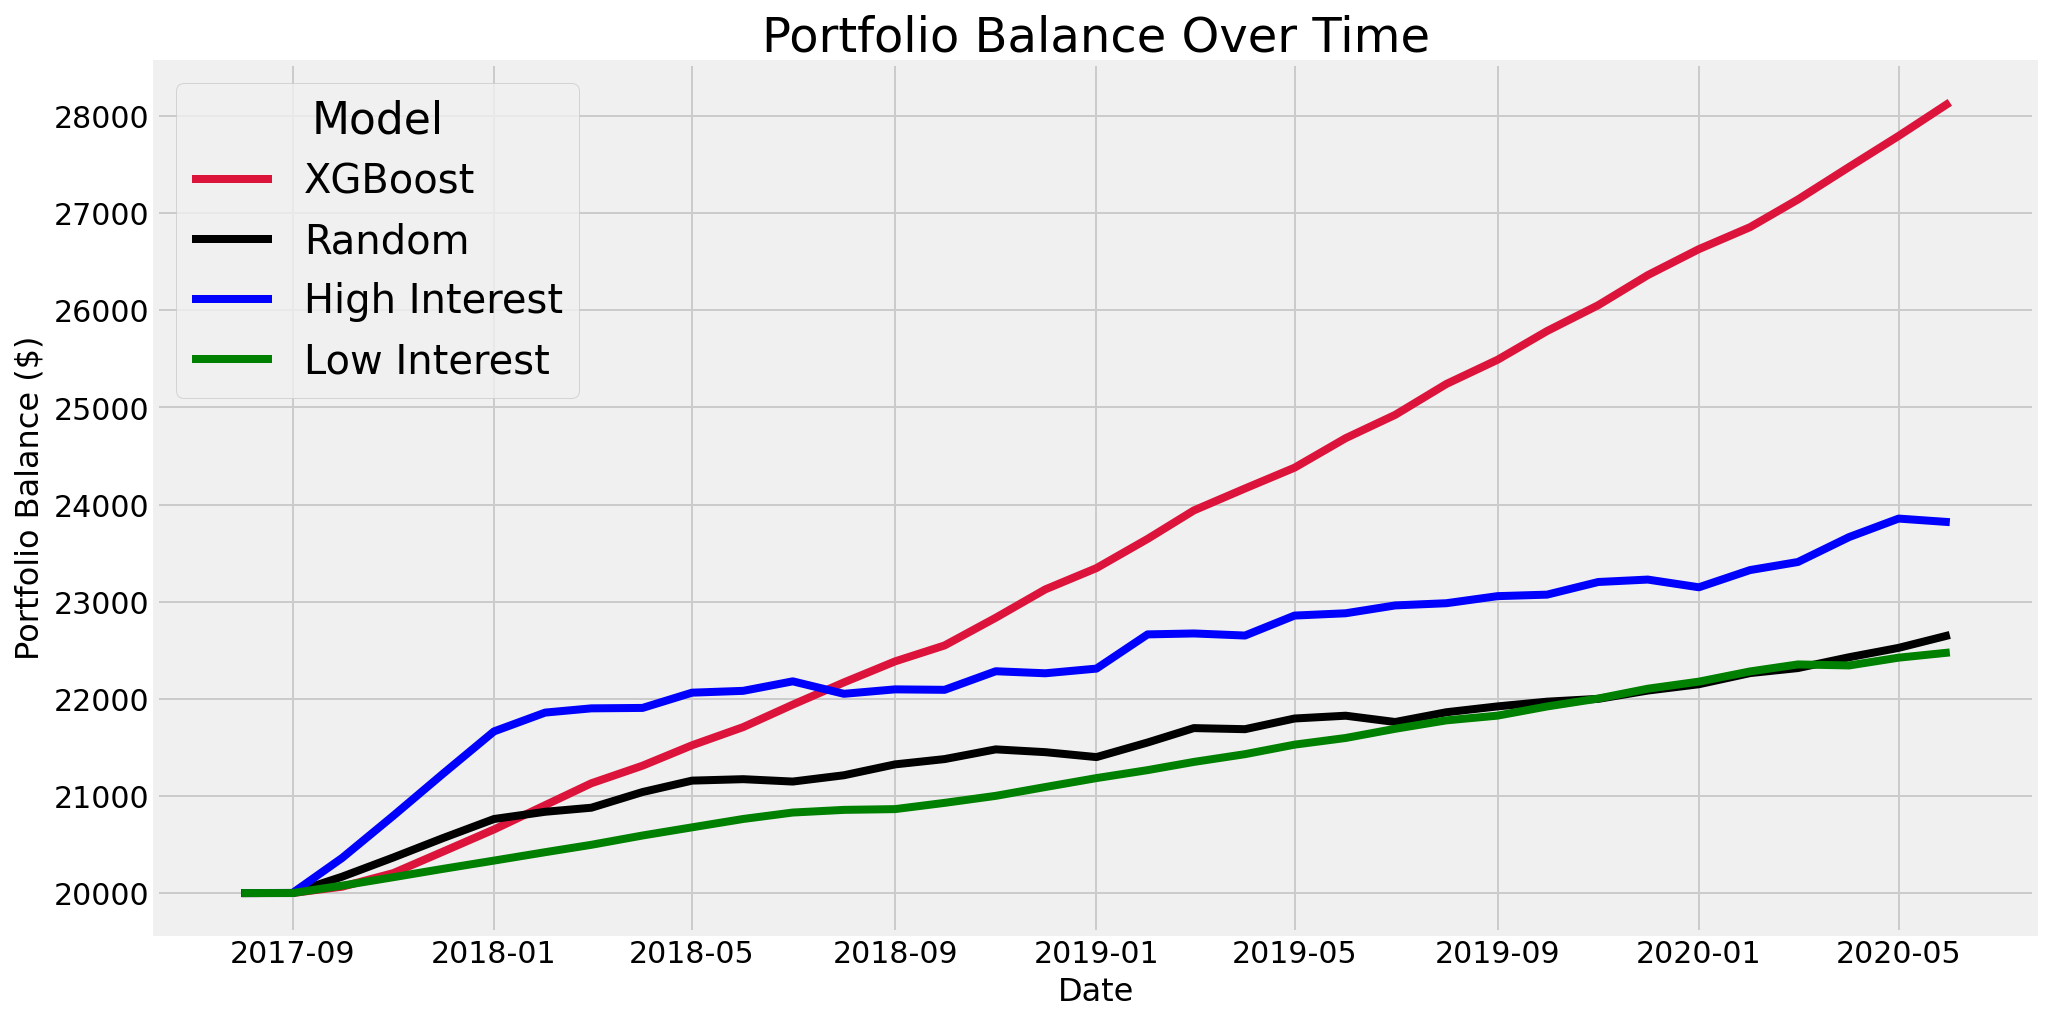

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dates, balances_xgb, color='crimson', label='XGBoost')
ax.plot(dates, balances_random, color='black', label='Random')
ax.plot(dates, balances_high_interest, color='blue', label='High Interest')
ax.plot(dates, balances_low_interest, color='green', label='Low Interest')
ax.set_title('Portfolio Balance Over Time', fontsize=24)
ax.set_ylabel('Portfolio Balance ($)', fontsize=16)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(axis='x', labelsize=15)
ax.legend(fontsize=20, title_fontsize=22, title='Model');

The untuned XGBoost model saw performance far superior to any other model. Additionally, selecting the lowest interest rate loans had essentially the same performance as just selecting loans randomly. For nearly a year it seems selecting loans with high interest rates was better than XGBoost, but it looks like those loans defaulted over time, giving the XGBoost model the advantage.

It will be interesting to see how performance changes once I add more models and do hyperparameter tuning.

Now that we can see the XGBoost predictions are currently our best options, let's use the simulator to determine what `minimum_roi` parameter value would've given us the best return, given that we have \\$20,000 to invest and are investing $25 per loan.

In [15]:
min_rois = np.linspace(7, 10, num = 50)
rois = []
balances = []

for roi in min_rois:
    myPortfolio = Portfolio(20000, 25, datetime.date(2017,8,1), predictions_xgb, payments, min_roi=roi)
    while myPortfolio.date < datetime.date(2020,7,1):
        myPortfolio.simulate_month()
    rois.append(roi)
    balances.append(myPortfolio.total_balance)

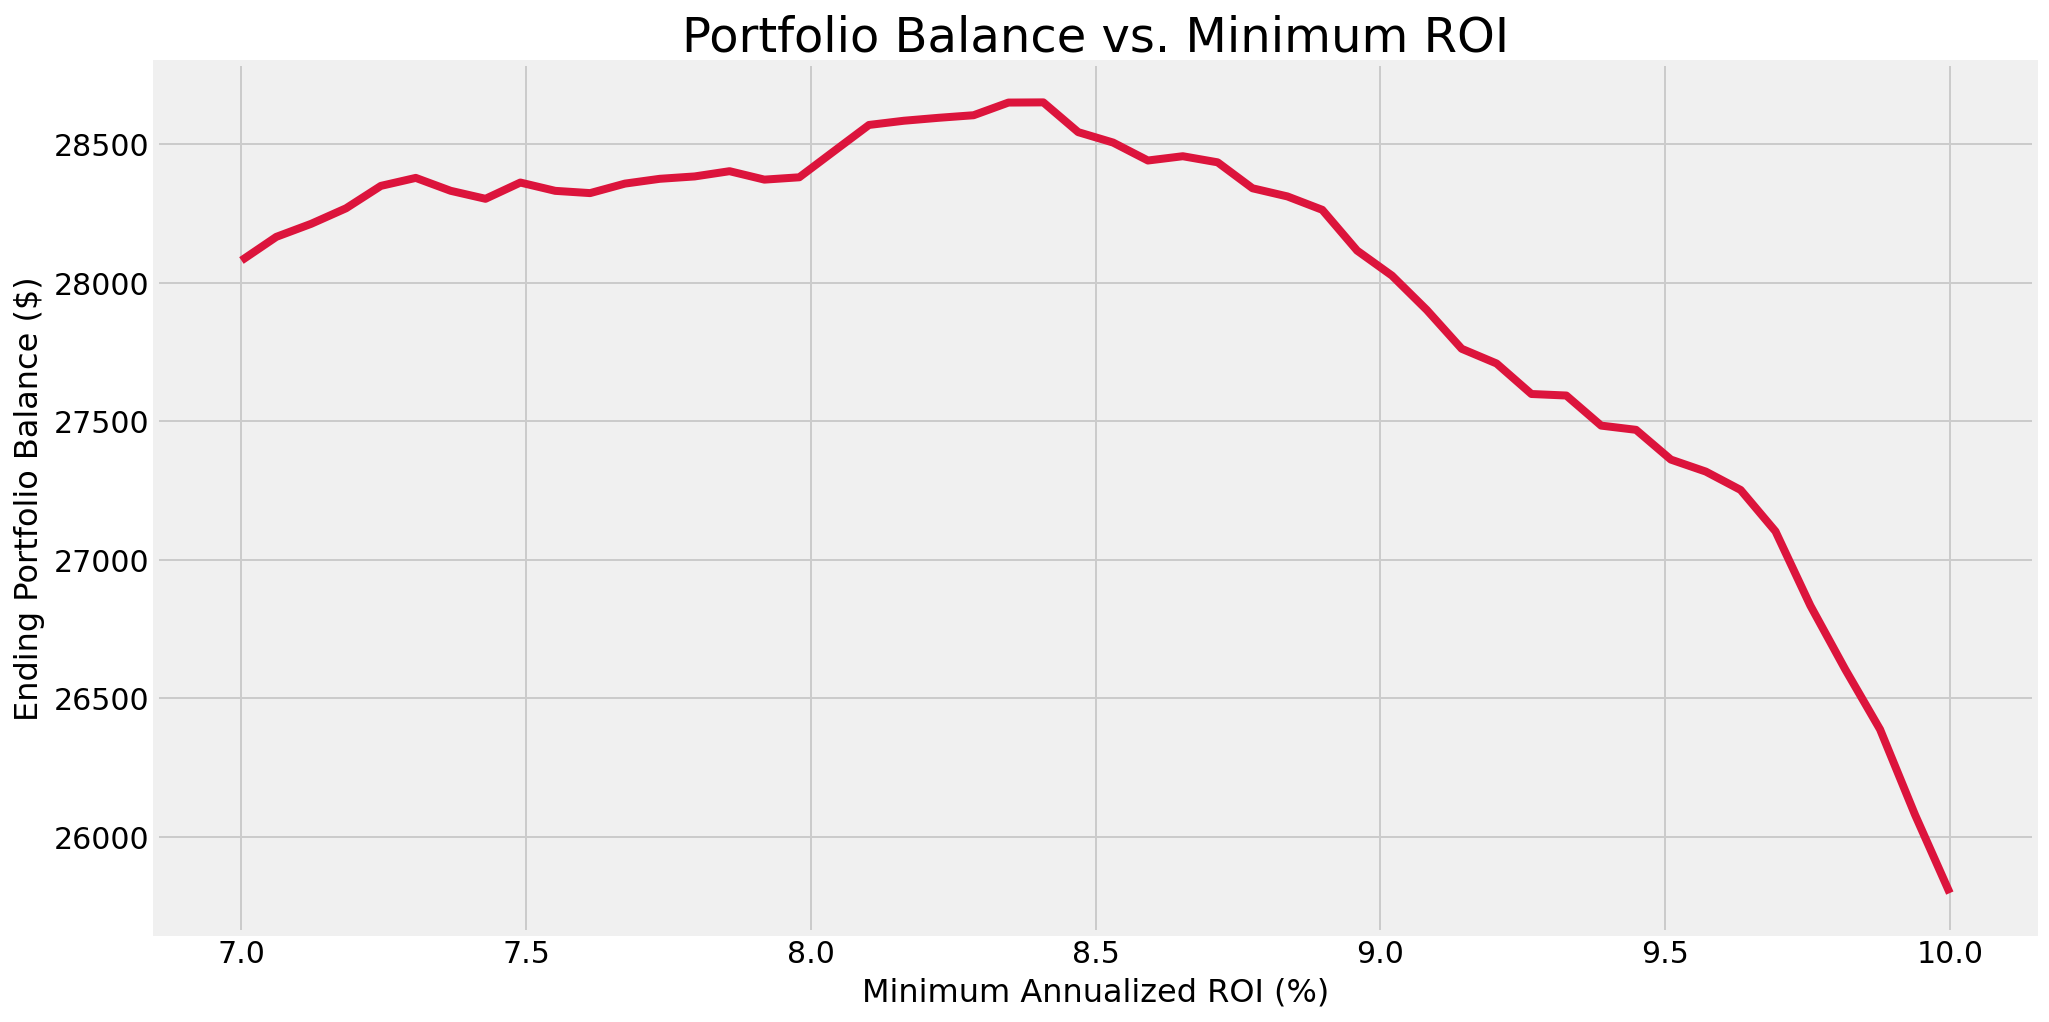

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(rois, balances, color='crimson', label='XGBoost')
ax.set_title('Portfolio Balance vs. Minimum ROI', fontsize=24)
ax.set_ylabel('Ending Portfolio Balance ($)', fontsize=16)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Minimum Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

In [25]:
i_best = np.argmax(np.array(balances))
rois[23]

8.408163265306122

A minimum ROI of 8.408% lead to the highest portfolio balance over the simulation when starting a portfolio worth \\$20,000 and investing $25 per loan. 

### Next Steps

This notebook has been a demonstration on how the portfolio simulator can be used to evaluate model performance on unseen loans. The next steps are to:

* Add more models
* Perform traditional cross validation and hyperparameter tuning
* Analyze SHAP values to try and interpret the best model

Stay turned for these updates.